In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer        

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#To split data into train and test
from sklearn.model_selection import train_test_split

#For fitting model
from sklearn.linear_model import LogisticRegression

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data collection

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [4]:
print(os.listdir(path))

df = pd.read_csv(path+'/train.csv')

print(df.head())

['sample_submission.csv', 'train.csv', 'test.csv']
       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [5]:
print(df.info())
print("Columns: " + df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24732 entries, 0 to 24731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         24732 non-null  object
 1   text           24732 non-null  object
 2   selected_text  24732 non-null  object
 3   sentiment      24732 non-null  object
dtypes: object(4)
memory usage: 773.0+ KB
None
Index(['Columns: textID', 'Columns: text', 'Columns: selected_text',
       'Columns: sentiment'],
      dtype='object')
(24732, 4)


In [6]:
df.describe(include='all')

,textID,text,selected_text,sentiment
count,24732,24732,24732,24732
unique,24732,24732,20298,3
top,28ac06f416,good luck with your auction,love,neutral
freq,1,1,174,10018


In [7]:
df['sentiment'].value_counts()

sentiment
neutral     10018
positive     7711
negative     7003
Name: count, dtype: int64

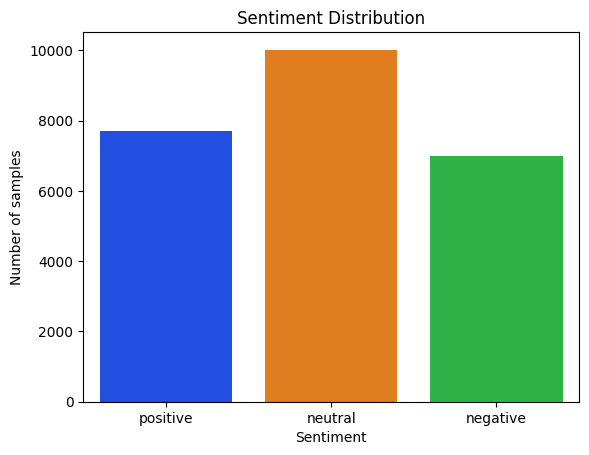

In [8]:
# Plot
sns.countplot(x='sentiment', data=df, palette='bright')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of samples')
plt.show()

# Preprocessing

## Text cleansing

In [9]:
'''
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Carica modello spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personalizzate (manteniamo le negazioni)
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # Rimuove punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizzazione
    tokens = word_tokenize(text.lower())
    
    # Lemmatizzazione con spaCy (sul testo completamente lowercase)
    doc = nlp(" ".join(tokens).lower())
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    
    # Rimozione stopwords
    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]
    
    return final_tokens

df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))
'''

'\nimport nltk\nimport spacy\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nimport string\n\n\n# Carica modello spaCy\nnlp = spacy.load("en_core_web_sm")\n\n# Stopwords personalizzate (manteniamo le negazioni)\nstop_words = set(stopwords.words(\'english\'))\nnegations = {\'no\', \'not\', \'nor\'}\nstop_words = stop_words.difference(negations)\n\ndef preprocess_text(text):\n    # Rimuove punteggiatura\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    \n    # Tokenizzazione\n    tokens = word_tokenize(text.lower())\n    \n    # Lemmatizzazione con spaCy (sul testo completamente lowercase)\n    doc = nlp(" ".join(tokens).lower())\n    lemmatized_tokens = [token.lemma_.lower() for token in doc]\n\n    \n    # Rimozione stopwords\n    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]\n    \n    return final_tokens\n\ndf[\'removed_stop_words\'] = df[\'text\'].apply(lambda x: preprocess

In [10]:
!pip install spacy nltk num2words
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3a3ff8ec72a61b10a72822994716ed84aff5bd3fe4746174a11f10b93b01834c
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.7 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load th

In [11]:
import re
import string
import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from num2words import num2words

# Downloads if needed
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom stopwords keeping negations
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # 3. Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Convert numbers to words
    def replace_numbers(match):
        return num2words(match.group())
    text = re.sub(r'\b\d+\b', replace_numbers, text)
    
    # 6. Lowercase
    text = text.lower()
    
    # 7. Lemmatize and tokenize with spaCy
    doc = nlp(text)
    
    # 8. Remove stopwords and non-alpha tokens
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in stop_words and token.lemma_.isalpha()
    ]
    
    return tokens


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [13]:
df.sample(10)

,textID,text,selected_text,sentiment,removed_stop_words
11625,4424d46fb8,"Never touched a drop, me!","Never touched a drop, me!",neutral,"[never, touch, drop]"
7759,d83003d8dc,miss my hubby already!,miss my hubby already!,negative,"[miss, hubby, already]"
6463,62dcce3464,"Garden going well, almost all the corn and pea...","well,",positive,"[garden, go, well, almost, corn, pea, no, onio..."
11989,98b26a12ae,"If they recorded it and sent it to people, th...","But if they didn`t, I feel bad.",negative,"[record, send, people, obviously, mean, get, n..."
20804,23e389c64f,"eesh, sorry to hear that. That isn`t going to...",", sorry",negative,"[eesh, sorry, hear, not, go, make, travel, mic..."
3798,b15a057274,Well that just sucks. Good way to make me feel...,Well that just sucks. Good way to make me feel...,neutral,"[well, suck, good, way, make, feel, bad]"
2151,c48acac3b2,Arrogant **** on tap in Oregon. WHAT!!!!!!,****,negative,"[arrogant, tap, oregon]"
7763,cb5d0bd12c,haha best thing about office birthdays hey,best,positive,"[haha, good, thing, office, birthday, hey]"
4818,a16e49148d,hey!! how are you??? you found me,hey!! how are you??? you found me,neutral,"[hey, find]"
5135,f3577d4cc4,I`m SO jealous- it`s pouring right now,jealous-,negative,"[jealous, pour, right]"


In [23]:
df[df['removed_stop_words'].apply(lambda tokens: 'mother' in tokens)]


,textID,text,selected_text,sentiment,removed_stop_words,polarity,intensity,sentiment_scores
19,fe54c45844,can`t believe I just drove all the way back to...,HAPPY,positive,"[not, believe, drive, way, back, schoolwhateve...",positive,0.8455,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."
52,f22dd850f7,happy mother`s day to all the moms out there. ...,happy mother`s day,positive,"[happy, mother, day, mom, hope, never, join, c...",positive,0.6919,"{'neg': 0.097, 'neu': 0.564, 'pos': 0.339, 'co..."
63,4e53704d24,in about 30 minutes Happy Mothers Day to alll ...,Happy,positive,"[thirty, minute, happy, mother, day, alll, ama...",positive,0.8647,"{'neg': 0.0, 'neu': 0.634, 'pos': 0.366, 'comp..."
93,ee91ba580f,Happy Mother`s Day ~ Did you watch SNL? If n...,Happy Mother`s Day,positive,"[happy, mother, day, watch, snl, not, u, miss,...",positive,0.6796,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp..."
110,8976579aa1,"Mom, where ever you are; Happy Mothers day",Happy,positive,"[mom, ever, happy, mother, day]",positive,0.5719,"{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp..."
...,...,...,...,...,...,...,...,...
24548,dbb2960dc7,Searching my home for a few things to cook the...,Searching my home for a few things to cook the...,neutral,"[search, home, thing, cook, dinner, evening, m...",neutral,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
24588,ba0f683c89,"Wishing you a very Happy Mother`s Day, Carina...",Happy,positive,"[wish, happy, mother, day, carina, hugsjoy]",positive,0.7563,"{'neg': 0.0, 'neu': 0.481, 'pos': 0.519, 'comp..."
24626,563148673a,happy mothers day,happy mo,positive,"[happy, mother, day]",positive,0.5719,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp..."
24691,a1c8f1e077,Happy Mothers Day! i hope tom got you somethi...,Happy Mothers Day!,positive,"[happy, mother, day, hope, tom, get, something...",positive,0.9243,"{'neg': 0.0, 'neu': 0.374, 'pos': 0.626, 'comp..."


In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the unique sentiment classes you want to generate clouds for
sentiments = ['neutral', 'positive', 'negative']

# Loop through each class
for sentiment in sentiments:
    # Filter the DataFrame by sentiment class
    subset = df[df['sentiment'] == sentiment]

    # Flatten the token lists into a single string
    all_words = ' '.join([' '.join(tokens) for tokens in subset['removed_stop_words']])

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Display the word cloud (optional)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} WordCloud', fontsize=16)

    # Save the figure locally
    filename = f"{sentiment}_wordcloud.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close the plot to avoid displaying all of them in notebook

    print(f"Saved: {filename}")


Saved: neutral_wordcloud.png
Saved: positive_wordcloud.png
Saved: negative_wordcloud.png
